<a href="https://colab.research.google.com/github/francescapozzi3/dd-02-dd/blob/main/dd_02_dd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Restricted Additive Schwarz preconditioner with coarse correction on a 2D domain**

**Advanced Methods For Scientific Computing**

Politecnico di Milano, January 2026



**[GitHub Repo](https://github.com/francescapozzi3/dd-02-dd/)**



Micaela Perlini	 10860443

Francesca Marina Pozzi  10837189

Martina Rusconi  10857811

In [1]:
!git clone https://github.com/francescapozzi3/dd-02-dd/

Cloning into 'dd-02-dd'...
remote: Enumerating objects: 405, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 405 (delta 3), reused 2 (delta 2), pack-reused 377 (from 1)
Receiving objects: 100% (405/405), 6.49 MiB | 10.03 MiB/s, done.
Resolving deltas: 100% (221/221), done.


In [2]:
%cd dd-02-dd/src

/content/dd-02-dd/src


In [3]:
!apt-get install libeigen3-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  libeigen3-doc libmpfrc++-dev
The following NEW packages will be installed:
  libeigen3-dev
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 1,056 kB of archives.
After this operation, 9,081 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libeigen3-dev all 3.4.0-2ubuntu2 [1,056 kB]
Fetched 1,056 kB in 1s (784 kB/s)
Selecting previously unselected package libeigen3-dev.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../libeigen3-dev_3.4.0-2ubuntu2_all.deb ...
Unpacking libeigen3-dev (3.4.0-2ubuntu2) ...
Setting up libeigen3-dev (3.4.0-2ubuntu2) ...


In [4]:
!make all

mpicxx -O3 -std=c++17 -Wall -I../include -I/usr/include/eigen3 -c main.cpp -o ../build/main.o
mpicxx -O3 -std=c++17 -Wall -I../include -I/usr/include/eigen3 -c ras_2d.cpp -o ../build/ras_2d.o
mpicxx -O3 -std=c++17 -Wall -o ../build/ras_2d_mpi ../build/main.o ../build/ras_2d.o


In [6]:
!mpirun --allow-run-as-root --oversubscribe -np 2 ../build/ras_2d_mpi 150 150 2.0 2.0 1.0 0.1 2 1000 1e-6 30

======== PARALLEL RAS SOLVER 2D =======
  Grid size:             150 x 150
  Coarse grid size:      8 x 8
  Processes:             2 (2 x 1 grid)
  Overlap:               2 cells
  Diffusion coefficient: 1
  Reaction coefficient:  0.1
------------------------------------

Starting BiCGSTAB with:
  Max iterations: 1000
  Tolerance: 1e-06

Preconditioner: Two-Level (RAS + Coarse Grid)

BiCGSTAB CONVERGED successfully!
  Iterations: 22
  Final residual: 6.62775e-07

File solution.csv written by rank 0.

======== TIMING ========
Total solver time: 187 ms
                   0.187 s


Loading 'solution.csv'...
Detected grid from file: Nx=150, Ny=150, hx=0.0134228, hy=0.0134228
Solve reference problem (direct sparse solve)...
Relative L2 error (file vs ref): 1.388956e-06
Max abs difference: 5.014854e-07
Plots saved in: solution_mpi.png, solution_mpi_pmesh.png, solution_ref.png, solution_diff.png, solution_slice.png, solution_3d_surface_mpi.png, solution_3d_surface_ref.png
(Note: parameters were read from the trailing 'params' line in the CSV.)


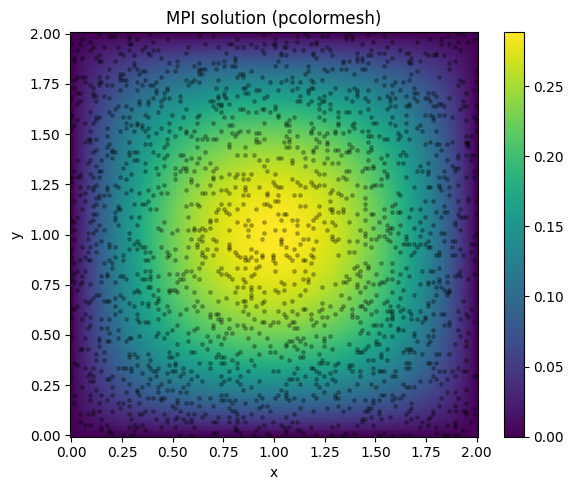

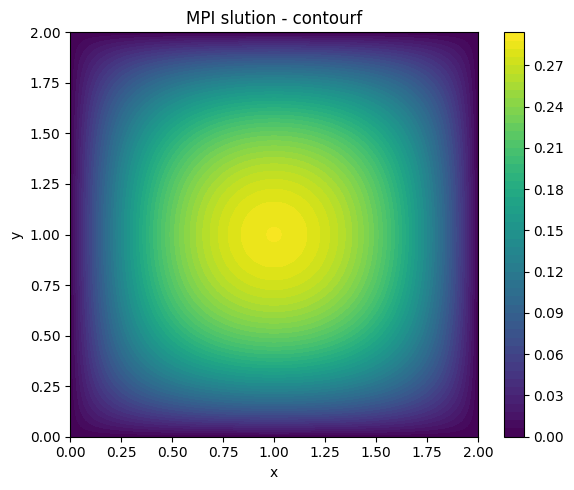

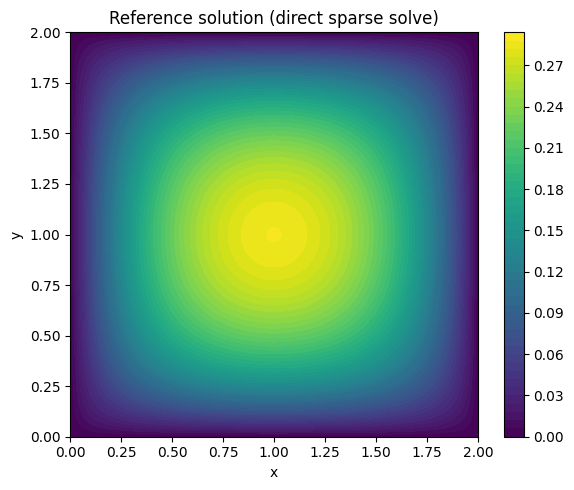

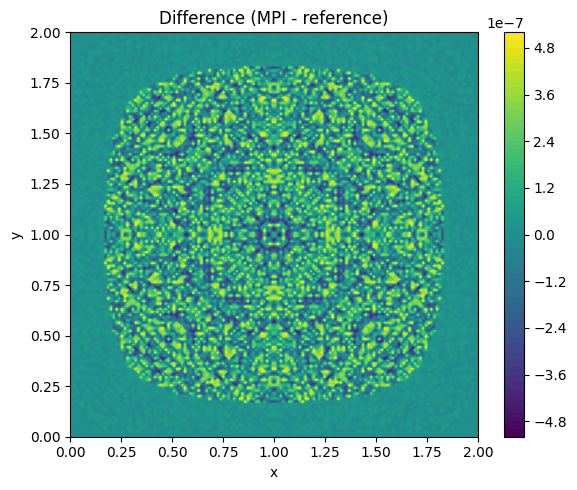

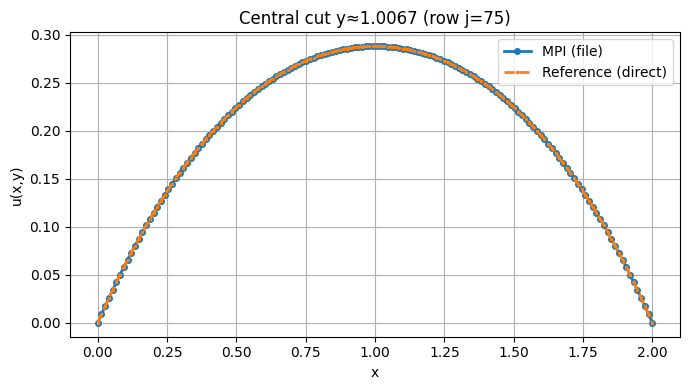

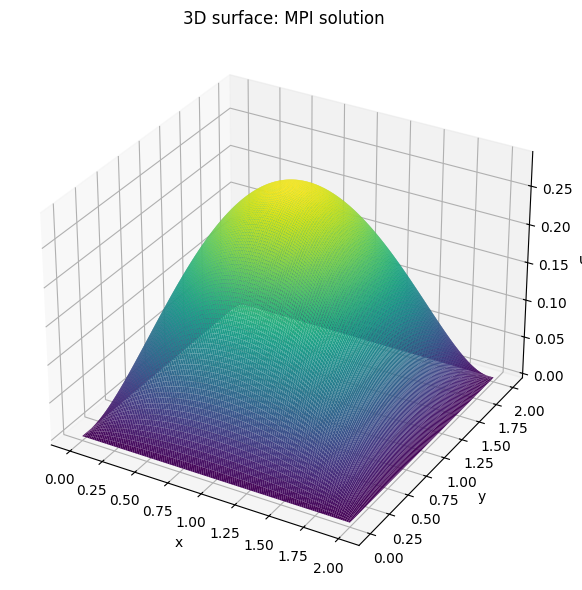

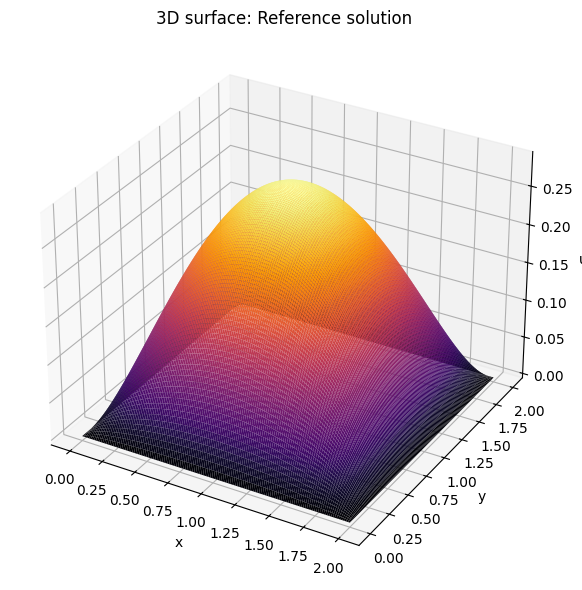

In [7]:
import os
import io
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (used by mpl)
import matplotlib.cm as cm

fname = 'solution.csv'

if not os.path.exists(fname):
    print(f"Error: '{fname}' not found. Please run the solver to produce '{fname}' and try again.")
    sys.exit(1)

print(f"Loading '{fname}'...")

# Read file lines and check for a trailing params line that we will remove before parsing
with open(fname, 'r') as f:
    lines = [ln for ln in f.readlines() if ln.strip() != '']
param_dict = {}
params_line = None
if len(lines) > 0 and lines[-1].startswith('params,'):
    params_line = lines.pop().strip()
    # parse params_line
    toks = params_line.split(',')[1:]
    # two possible formats: key=value or plain values in fixed order
    if any('=' in t for t in toks):
        for t in toks:
            if '=' in t:
                k,v = t.split('=',1)
                param_dict[k.strip()] = v.strip()
    else:
        # fixed order: Nx,Ny,Lx,Ly,mu,c,overlap,maxit,tol,restart
        keys = ['Nx','Ny','Lx','Ly','mu','c','overlap','maxit','tol','restart']
        for k,t in zip(keys, toks):
            param_dict[k] = t

# Reconstruct csv content without the params line for pandas
content = ''.join(lines)
try:
    df = pd.read_csv(io.StringIO(content))
except Exception as e:
    raise RuntimeError(f"Failed to parse CSV data (without params line): {e}")


# compute hx, hy
#hx = x_unique[1] - x_unique[0] if Nx_file > 1 else 1.0
#hy = y_unique[1] - y_unique[0] if Ny_file > 1 else 1.0

# assicurati che il DataFrame sia in ordine coerente (y, x)
df = df.sort_values(['y','x']).reset_index(drop=True)

x_unique = np.sort(df['x'].unique())
y_unique = np.sort(df['y'].unique())
Nx_file = len(x_unique); Ny_file = len(y_unique)

# hx, hy più robusti: usa range o i parametri se presenti
if Nx_file > 1:
    if 'Lx' in param_dict:
        hx = float(param_dict['Lx']) / (Nx_file - 1)
    else:
        hx = (x_unique[-1] - x_unique[0]) / (Nx_file - 1)
else:
    hx = 1.0

if Ny_file > 1:
    if 'Ly' in param_dict:
        hy = float(param_dict['Ly']) / (Ny_file - 1)
    else:
        hy = (y_unique[-1] - y_unique[0]) / (Ny_file - 1)
else:
    hy = 1.0

print(f"Detected grid from file: Nx={Nx_file}, Ny={Ny_file}, hx={hx:.6g}, hy={hy:.6g}")

# reshape u into a 2D array with shape (Ny, Nx) in plotting (Y rows)
try:
    U_file = df['u'].values.reshape((Ny_file, Nx_file))
except Exception as e:
    raise RuntimeError(f"Error reshaping u to (Ny,Nx): {(Ny_file,Nx_file)} - {e}")

# Build reference sparse system using provided mu and c (from params) or defaults
mu = float(param_dict.get('mu', 1.0))
c = float(param_dict.get('c', 0.1))
N = Nx_file * Ny_file
rows = []; cols = []; vals = []; b = np.zeros(N)
for j in range(Ny_file):
    for i in range(Nx_file):
        k = i + j * Nx_file
        if i == 0 or i == Nx_file-1 or j == 0 or j == Ny_file-1:
            rows.append(k); cols.append(k); vals.append(1.0)
            b[k] = 0.0
        else:
            idx2 = 1.0/(hx*hx); idy2 = 1.0/(hy*hy)
            center = mu * (2.0*idx2 + 2.0*idy2) + c
            offx = -mu * idx2
            offy = -mu * idy2
            rows.extend([k,k,k,k,k])
            cols.extend([k, k-1, k+1, k-Nx_file, k+Nx_file])
            vals.extend([center, offx, offx, offy, offy])
            b[k] = 1.0

A = sp.csr_matrix((vals,(rows,cols)), shape=(N,N))

print("Solve reference problem (direct sparse solve)...")
u_ref = spla.spsolve(A, b)
U_ref = u_ref.reshape((Ny_file,Nx_file))

# compute difference and norms
U_file = U_file.astype(np.float64)
U_ref = U_ref.astype(np.float64)

diff = U_file - U_ref
l2_err = np.sqrt(np.sum(diff**2)) / np.sqrt(np.sum(U_ref**2)) if np.sum(U_ref**2) != 0 else np.nan
max_abs = np.max(np.abs(diff))

print(f"Relative L2 error (file vs ref): {l2_err:.6e}")
print(f"Max abs difference: {max_abs:.6e}")

# create mesh for plotting
X, Y = np.meshgrid(x_unique, y_unique)

# ---------- Efficient 2D visualization: pcolormesh ----------
plt.figure(figsize=(6,5))
plt.title("MPI solution (pcolormesh)")
pcm = plt.pcolormesh(X, Y, U_file, shading='auto')
plt.colorbar(pcm)
plt.xlabel("x"); plt.ylabel("y")
# downsample if we have to many points
num_points = X.size
max_scatter = 2000
if num_points <= max_scatter:
    plt.scatter(X.ravel(), Y.ravel(), s=6, c='k', alpha=0.25)
else:
    idx = np.random.choice(num_points, size=max_scatter, replace=False)
    plt.scatter(X.ravel()[idx], Y.ravel()[idx], s=6, c='k', alpha=0.25)
plt.tight_layout()
plt.savefig("solution_mpi_pmesh.png")

# --- Plot 1: MPI solution (contourf) ---
plt.figure(figsize=(6,5))
plt.title("MPI slution - contourf")
plt.contourf(X, Y, U_file, levels=50)
plt.colorbar()
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout()
plt.savefig("solution_mpi.png")

# --- Plot 2: Reference direct solve (contourf) ---
plt.figure(figsize=(6,5))
plt.title("Reference solution (direct sparse solve)")
plt.contourf(X, Y, U_ref, levels=50)
plt.colorbar()
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout()
plt.savefig("solution_ref.png")

# --- Plot 3: Difference ---
plt.figure(figsize=(6,5))
plt.title("Difference (MPI - reference)")
plt.contourf(X, Y, diff, levels=50)
plt.colorbar()
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout()
plt.savefig("solution_diff.png")

# --- Plot 4: central slice comparison ---
yc = y_unique.mean()
j_center = np.argmin(np.abs(y_unique - yc))
plt.figure(figsize=(7,4))
plt.title(f"Central cut y≈{y_unique[j_center]:.4f} (row j={j_center})")
plt.plot(x_unique, U_file[j_center,:], label="MPI (file)", linestyle='-', linewidth=2, marker='o', markersize=4)
plt.plot(x_unique, U_ref[j_center,:], label="Reference (direct)", linestyle='--', linewidth=2, marker='s', markersize=2)
plt.xlabel("x"); plt.ylabel("u(x,y)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("solution_slice.png")

# ---------- 3D surface plot (MPI) ----------
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D surface: MPI solution')
max_side = 200  # if Nx or Ny > max_side, downsample for performance
step_x = max(1, Nx_file // max_side)
step_y = max(1, Ny_file // max_side)
Xs = X[::step_y, ::step_x]
Ys = Y[::step_y, ::step_x]
Us = U_file[::step_y, ::step_x]
ax.plot_surface(Xs, Ys, Us, rstride=1, cstride=1, cmap=cm.viridis, linewidth=0, antialiased=True)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('u')
plt.tight_layout()
plt.savefig('solution_3d_surface_mpi.png')

# ---------- 3D surface plot (Reference) ----------
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D surface: Reference solution')
Xs = X[::step_y, ::step_x]
Ys = Y[::step_y, ::step_x]
Us_ref = U_ref[::step_y, ::step_x]
ax.plot_surface(Xs, Ys, Us_ref, rstride=1, cstride=1, cmap=cm.inferno, linewidth=0, antialiased=True)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('u')
plt.tight_layout()
plt.savefig('solution_3d_surface_ref.png')

print("Plots saved in: solution_mpi.png, solution_mpi_pmesh.png, solution_ref.png, solution_diff.png, solution_slice.png, solution_3d_surface_mpi.png, solution_3d_surface_ref.png")
if params_line is not None:
    print("(Note: parameters were read from the trailing 'params' line in the CSV.)")
